In [1]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import dstep
from scipy import signal
from scipy.linalg import expm
from numpy.linalg import multi_dot
from scipy.signal import cont2discrete
from scipy.integrate import solve_ivp

In [2]:
# # Constant
# Ci = 0.1367
# Ti = 0.7293
# ui = 390
# cdes = 0.0944 # c/cf
# Tdes = 0.7766 # 
# u1des = 0.05  # final inverse theta
# u2des = 340  # final heat transfer rate
# # c_final = 0.05 # c/cf
# # T_final = 0.38 # 

# alpha = 1.95e-4
# alpha1 = 1e6
# alpha2 = 2e3
# alpha3 = 1e-3
# k10 = 300
# n = 5
# cf = 7.6
# tf = 300
# tc = 290

# yf = 0.3947
# yc = 0.3816
# # time = 10
# # point = 0
# # nfe = 100
# # ncp = 3

In [3]:
# Constant
Ci = 0.1367    # initial concentration
Ti = 0.7293    # initial temperature
u1i = 0.05
u2i = 390      # initial heat transfer rate, u2

cdes = 0.0944  # final concentration, x1/y1
Tdes = 0.7766  # final temperature, x2/y2
u1des = 0.05   # final inverse theta, u1
u2des = 340    # final heat transfer rate, u2

alpha = 1.95e-4
alpha1 = 1e6
alpha2 = 2e3
alpha3 = 1e-3
k10 = 300      # rate constant
n = 5
Cf = 7.6       # feed concentration
Tf = 300       # feed temperature
Tc = 290       # coolant temperature

yf = 0.3947
yc = 0.3816

# Model and Simulate ODE system for CSTR

In [4]:
# ODE
# Input values select
u1 = u1des
u2 = u2des
def ODE(t,variables):
  C, T = variables
 
  dcdt = (1-C)*u1-k10*np.exp(-n/T)*C
  dTdt = (yf-T)*u1-k10*np.exp(-n/T)*C+alpha*u2*(yc-T)
  return [dcdt, dTdt]

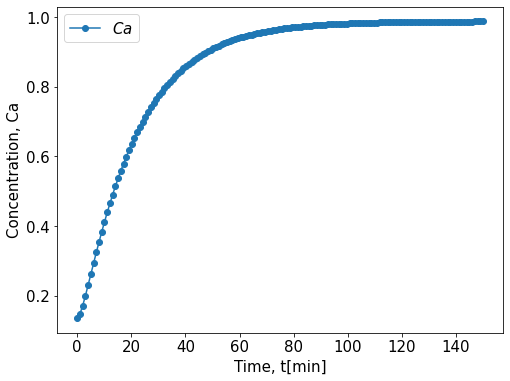

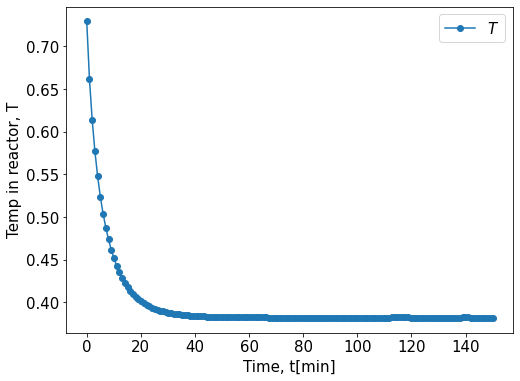

In [5]:
init_vars = np.array([Ci, Ti])
tspan = np.array((0, 150))           # min
teval = np.linspace(*tspan, 150) 
sol = solve_ivp(fun=ODE, t_span=tspan, y0=init_vars, t_eval=teval)

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
plt.plot(sol.t, sol.y[0],'o-', label = '$Ca$')
plt.legend()
plt.xlabel('Time, t[min]') 
plt.ylabel('Concentration, Ca')

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
plt.plot(sol.t, sol.y[1], 'o-', label = '$T$') 
plt.legend()
plt.xlabel('Time, t[min]') 
plt.ylabel('Temp in reactor, T')
plt.show()

# Discrete-time state-space form for ODE sytem

In [6]:
# # ABCD Calculation
# import sympy as sp
# from IPython.display import display, Latex
# C, u1, u2, k10, n, T, alpha, yf, yc, Cf = sp.symbols('C, u1, u2, k10, n, T, alpha, yf, yc, Cf')
# dcdt = (1-C)*u1-k10*sp.exp(-n/T)*C
# dTdt = (yf-T)*u1+Cf*k10*sp.exp(-n/T)*C+alpha*u2*(yc-T)
# A11 = sp.diff(dcdt, C)
# display(A11)
# A12 = sp.diff(dcdt, T)
# display(A12)
# A21 = sp.diff(dTdt, C)
# display(A21)
# A22 = sp.diff(dTdt, T)
# display(A22)
# B11 = sp.diff(dcdt, u1)
# display(B11)
# B12 = sp.diff(dcdt, u2)
# display(B12)
# B21 = sp.diff(dTdt, u1)
# display(B21)
# B22 = sp.diff(dTdt, u2)
# display(B22)

In [7]:
A11= -k10*np.exp(-n/Tdes)-u1
A12 = -cdes*k10*n*np.exp(-n/Tdes)/Tdes**2
A21 = k10*np.exp(-n/Tdes)
A22 = cdes*k10*n*np.exp(-n/Tdes)/Tdes**2-alpha*u2-u1
A = np.array([[A11,A12],
              [A21,A22]])
A

array([[-0.52972684, -0.37544061],
       [ 0.47972684,  0.25914061]])

In [8]:
B11 = 1-cdes
B12 = 0
B21 = -Tdes+yf
B22 = alpha*(-Tdes+yc)
B = np.array([[B11,B12],
              [B21,B22]])
B

array([[ 9.0560e-01,  0.0000e+00],
       [-3.8190e-01, -7.7025e-05]])

In [9]:
C = np.array([[1,0],
              [0,1]])
D = np.zeros([2,2])

In [10]:
delta_t = 1        #min
sys_d = cont2discrete((A,B,C,D),delta_t,method='zoh')
sys_d

(array([[ 0.51965315, -0.32659319],
        [ 0.41731107,  1.20588349]]),
 array([[ 7.46126117e-01,  1.31923405e-05],
        [-2.26312395e-01, -8.56172099e-05]]),
 array([[1, 0],
        [0, 1]]),
 array([[0., 0.],
        [0., 0.]]),
 1)

In [11]:
phi = sys_d[0]
gamma = sys_d[1]
new_C = sys_d[2]
new_D = sys_d[3]

# Step Response Model

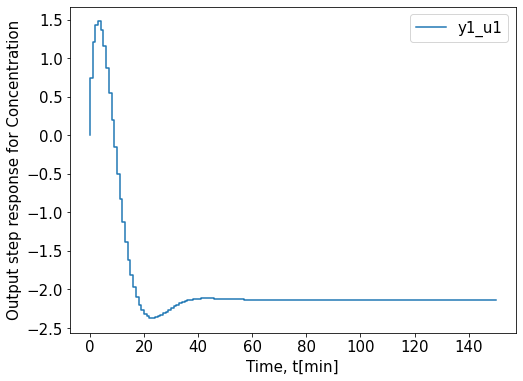

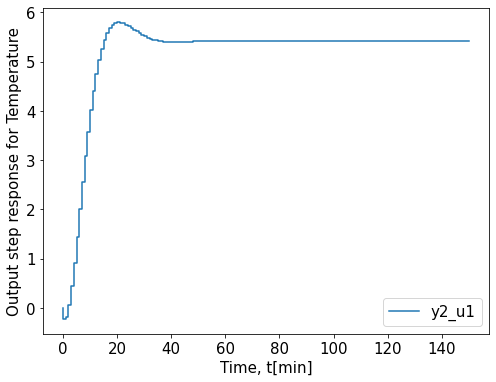

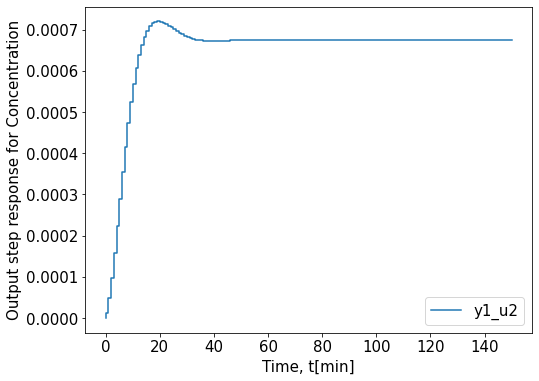

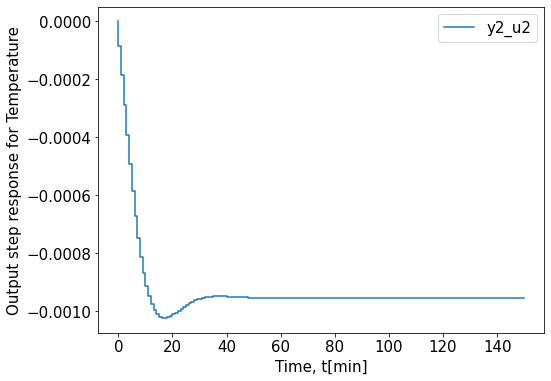

In [12]:
N = 150      # Simulation length
t_step,y_step = signal.dstep(sys_d,n=N+1)
y1_step_u1 = y_step[0][:,0]
y2_step_u1 = y_step[0][:,1]
y1_step_u2 = y_step[1][:,0]
y2_step_u2 = y_step[1][:,1]

plt.figure(figsize=(8,6))
# # plt.step(t_step, y_step[0:N+1])
plt.step(t_step, y1_step_u1, label='y1_u1')
plt.xlabel('Time, t[min]') 
plt.ylabel('Output step response for Concentration')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.step(t_step, y2_step_u1, label='y2_u1')
plt.xlabel('Time, t[min]') 
plt.ylabel('Output step response for Temperature')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.step(t_step, y1_step_u2, label='y1_u2')
plt.xlabel('Time, t[min]') 
plt.ylabel('Output step response for Concentration')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.step(t_step, y2_step_u2, label='y2_u2')
plt.xlabel('Time, t[min]') 
plt.ylabel('Output step response for Temperature')
plt.legend()
plt.show()